# Lab 3 (Part 2): Convolutional NNs for Fashion MNIST


------------------------------------------------------
*Deep Learning. Master in Information Health Engineering *

*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------


In this third lab of the lab, you'll be using again the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). Our goal is to present i) how CNN layers are used in Pytorch, and ii) evaluate the performance of a simple CNN over FNIST.

In [0]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

## Part I. Download FMNIST with `torchvision`

The code below will download the MNIST dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [0]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)

> **Exercise:** Create a validation set using the 20% of train images

In [0]:
print(0.8*len(trainset))

48000.0


In [0]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 48k images for training
trainloader.dataset.data = trainloader.dataset.data[:48000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:48000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[48000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[48000:]

## Part II. Implement Lenet 5

Our first goal is to implement the LeNet 5 CNN network, first published in November 1998. See the original paper [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [0]:
Image(url= "https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg")

In the CNN network above we have 2 convolutional layers with the following properties:

- ReLU activation functions are used as non-linear functions
- Maxpooling with $2\times 2$ kernels is used to reduce the spatial dimension in both layers.
- $5\times 5$ convolutional filters are used. Stride is 1.
- After the second convolutional layer, three dense layers are stacked. 

Note that FMNIST images are $28\times28$ (instead of $32\times32$), so some of the spatial dimensions in the image above are different.

> **Exercise:** Complete the following code that defines the above CNN. But first read the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html) documentation.

In [0]:
 class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5,stride=1 ,padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        
        # Linear layers
        self.dense1 = nn.Linear(self.final_dim*4*16,120)
        
        self.dense2 = nn.Linear(120,84)
        
        self.dense3 = nn.Linear(84,10)
        
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
        

        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x)
        x = self.relu(x) 
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
    
        # Flatten the tensor into a vector
        x = x.view(-1, 16 * self.final_dim**2)
       
        # Pass the tensor through the Dense Layers
        x=self.dense1(x)
        x = self.relu(x)
        x=self.dense2(x)
        x = self.relu(x)
        x=self.dense3(x)
        x = self.relu(x)
        x = self.logsoftmax(x)
        return x


Now the network is defined, by now you should know how to move forward by your own!!

> **Exercise:** Extend the class to incorporate a training method, to evaluate the both the validation and train losses and to evaluate the classification performance in a set.

In [0]:
class Lenet5_extended(Lenet5):
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels) 
        
        self.lr = lr 
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               
        
        self.loss_during_training = []
        
        self.validation_loss_during_training = []
    
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            running_loss = 0.
            
            for images, labels in trainloader:
            
              self.optim.zero_grad()

              out = self.forward(images)

              loss = self.criterion(out, labels)

              running_loss += loss.item()

              loss.backward()

              self.optim.step()   

            self.loss_during_training.append(running_loss/len(trainloader))  

            print("Epoch %d. Training loss: %f, Time per epoch: %f seconds" 
                      %(e, self.loss_during_training[-1], (time.time() - start_time)))
            
            with torch.no_grad():
              
              validation_total = 0             

              for images,labels in validloader:
                
                validation_out = self.forward(images)
                validation_loss = self.criterion(validation_out, labels)
                validation_total += validation_loss.item()
              
              self.validation_loss_during_training.append(validation_total/len(validloader))  


    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0
        
        with torch.no_grad():

            for images,labels in dataloader:

              probs = self.forward(images)
              it_loss = self.criterion(probs, labels)
              loss += it_loss.item()

              top_p, top_class = probs.topk(1, dim=1)
              equals = (top_class == labels.view(images.shape[0], 1))
              accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader), loss/len(dataloader)

> **Exercise:** Train the model for 5 epochs, plot the train/validation loss during training, and compute the train and validation performance. It will take some time!!

In [0]:
my_cnn = Lenet5_extended(dimx=28,nlabels=10,epochs=5,lr=1e-3)

my_cnn.trainloop(trainloader, validloader)

train_performance = my_cnn.eval_performance(trainloader)

test_performance = my_cnn.eval_performance(testloader)

print("Train Accuracy", train_performance)

print("Test Accuracy", test_performance)

Epoch 0. Training loss: 0.917918, Time per epoch: 11.502466 seconds
Epoch 1. Training loss: 0.535828, Time per epoch: 11.443442 seconds
Epoch 2. Training loss: 0.460588, Time per epoch: 11.636400 seconds
Epoch 3. Training loss: 0.416765, Time per epoch: 11.516643 seconds
Epoch 4. Training loss: 0.380773, Time per epoch: 11.718041 seconds
Train Accuracy (tensor(0.8635), 0.37664480586635307)
Test Accuracy (tensor(0.8485), 0.4203385181725025)


## Part III. GPU-based training

As you noticed, training became excessively slow. The newtork is already quite deep and gradient evaluation becomes a heavy operation. 

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

> **Exercise:** Complete the following class, which implements the CNN training and validation using a GPU (if possible). 

**Note: Google Colab Recommended**. When running the notebook in Google Colab, make sure you first to `Edit -- Notebook settings` and **select a GPU as Hardware accelerator.**

In [0]:
class Lenet5_extended_GPU(Lenet5):
    
    
    def __init__(self,dimx,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels)
        
        self.lr = lr 
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               
        
        self.loss_during_training = [] 
        
        self.validation_loss_during_training = [] 
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                self.optim.zero_grad()

                out = self.forward(images)

                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()
            
            self.loss_during_training.append(running_loss/len(trainloader))            
            
            print("Epoch %d. Training loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1], (time.time() - start_time)))
            
            with torch.no_grad():
              
              validation_total = 0             

              for images,labels in validloader:
                
                images, labels = images.to(self.device), labels.to(self.device)  
                
                validation_out = self.forward(images)
                validation_loss = self.criterion(validation_out, labels)
                validation_total += validation_loss.item()
              
            self.validation_loss_during_training.append(validation_total/len(validloader))  
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 

                probs = self.forward(images)
                it_loss = self.criterion(probs, labels)
                loss += it_loss.item()

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader), loss/len(dataloader)
    

> **Exercise:** By using Google Colab or a computer with a GPU, train the model for 5 epochs and check how long does it take now to train one epoch.

In [0]:
my_cnn = Lenet5_extended_GPU(dimx=28,nlabels=10,epochs=5,lr=1e-3)

my_cnn.trainloop(trainloader, validloader)

train_performance = my_cnn.eval_performance(trainloader)

test_performance = my_cnn.eval_performance(testloader)

print("Train Accuracy", train_performance)

print("Test Accuracy", test_performance)


Epoch 0. Training loss: 0.926735, Time per epoch: 5.899386 seconds
Epoch 1. Training loss: 0.547546, Time per epoch: 5.904766 seconds
Epoch 2. Training loss: 0.473664, Time per epoch: 5.808622 seconds
Epoch 3. Training loss: 0.422866, Time per epoch: 5.869111 seconds
Epoch 4. Training loss: 0.384556, Time per epoch: 5.793530 seconds
Train Accuracy (tensor(0.8679), 0.3670681429670212)
Test Accuracy (tensor(0.8538), 0.4057487562298775)


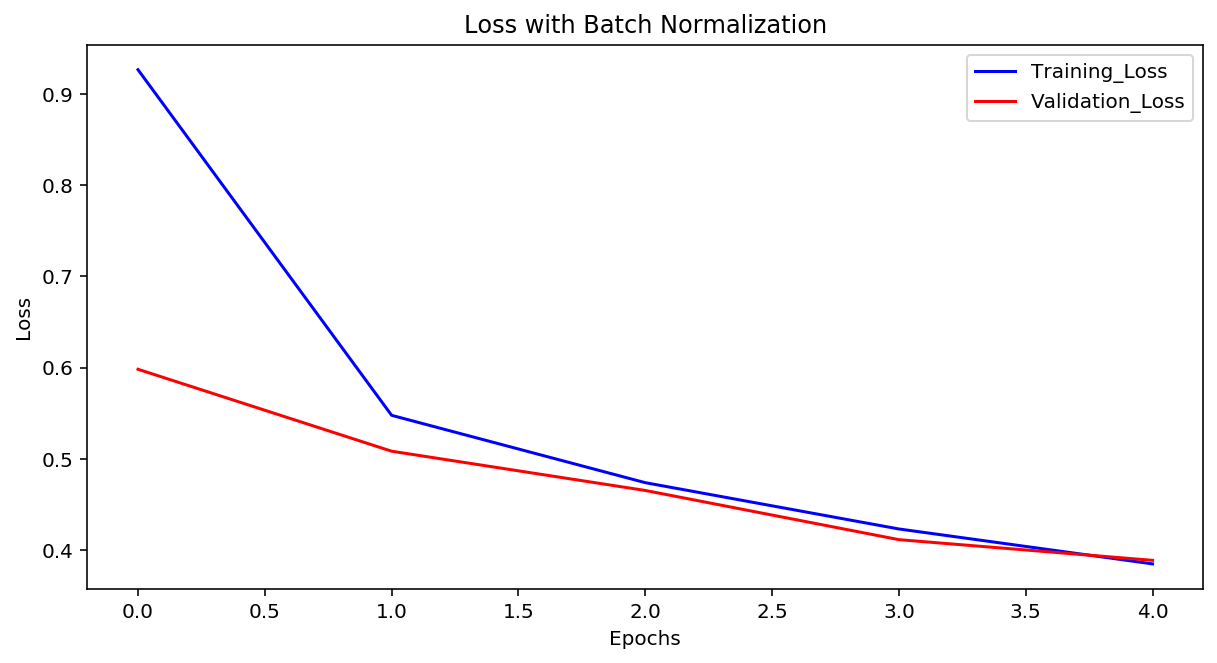

In [0]:
plt.figure(figsize=(10,5))
plt.plot(my_cnn.loss_during_training,'b', label='Training_Loss')
plt.plot(my_cnn.validation_loss_during_training,'r', label='Validation_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss with Batch Normalization')
plt.legend()
plt.show()

With a GPU, you will see that the time per epoch roughly decreases to the half. As we train deeper and much more complex networks, **this difference grows exponentially fast**. Using GPUs is a must for lage-scale deployment.

## Part IV. Regularize the network and compare with a MLP

> **Exercise**: Now that you know how to train the CNN network, your goals are:
> - Check that the CNN is able to overfit
> - Regularize the network with both early stopping and dropout. You can use a dropout layer after every layer of the network or only in one or two layers. **Validate this effect by comparing two different designs.** Note that once you include dropout, it wil take more epochs to get a good solution. The more dropout layers, the more epochs typically you have to run at least 50 epochs.
> - Compare the test performance achieved w.r.t. the MLP that was used in Lab 2

In [0]:
my_cnn_gpu = Lenet5_extended_GPU(dimx=28,nlabels=10,epochs=50,lr=1e-3)

my_cnn_gpu.trainloop(trainloader, validloader)

train_performance = my_cnn_gpu.eval_performance(trainloader)

test_performance = my_cnn_gpu.eval_performance(testloader)

print("Train Accuracy", train_performance)

print("Test Accuracy", test_performance)

Epoch 0. Training loss: 0.904410, Time per epoch: 5.804856 seconds
Epoch 1. Training loss: 0.540931, Time per epoch: 5.746655 seconds
Epoch 2. Training loss: 0.465839, Time per epoch: 5.742310 seconds
Epoch 3. Training loss: 0.417492, Time per epoch: 5.626568 seconds
Epoch 4. Training loss: 0.381146, Time per epoch: 5.591770 seconds
Epoch 5. Training loss: 0.357059, Time per epoch: 5.605786 seconds
Epoch 6. Training loss: 0.342273, Time per epoch: 5.569138 seconds
Epoch 7. Training loss: 0.326350, Time per epoch: 5.664747 seconds
Epoch 8. Training loss: 0.311548, Time per epoch: 5.565574 seconds
Epoch 9. Training loss: 0.303378, Time per epoch: 5.601811 seconds
Epoch 10. Training loss: 0.292464, Time per epoch: 5.654530 seconds
Epoch 11. Training loss: 0.284247, Time per epoch: 5.766732 seconds
Epoch 12. Training loss: 0.275065, Time per epoch: 5.705594 seconds
Epoch 13. Training loss: 0.266881, Time per epoch: 5.518508 seconds
Epoch 14. Training loss: 0.261711, Time per epoch: 5.49684

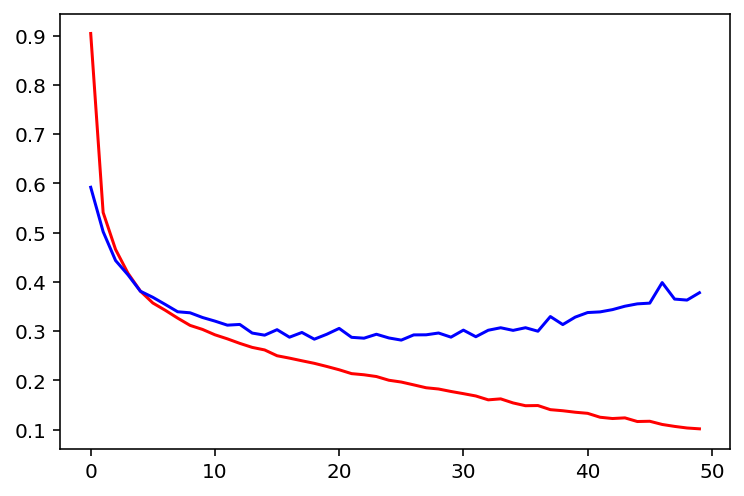

In [0]:
plt.figure()
plt.plot(my_cnn_gpu.loss_during_training, 'r')
plt.plot(my_cnn_gpu.validation_loss_during_training, 'b')
plt.show()

In [0]:
class Lenet5_dropout2(nn.Module):
    def __init__(self,dimx,nlabels,prob): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int((((dimx-4)/2)-4)/2)
        
        # Linear layers
        
        self.output1 = nn.Linear(16*self.final_dim**2, 120)
        
        self.output2 = nn.Linear(120,84)
        
        self.output3 = nn.Linear(84,nlabels)
    
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(p = prob)

        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.pool(self.relu(self.dropout(self.conv1(x))))
        x = self.pool(self.relu(self.dropout(self.conv2(x))))

        # Flatten the tensor into a vector
        x = x.view(-1, 16 * self.final_dim**2)
        # Pass the tensor through the Dense Layers
        
        x = self.relu(self.output1(x))
        x = self.relu(self.output2(x))
        x = self.logsoftmax(self.output3(x))
        
        return x


class Lenet5_dropout_all(nn.Module):
    def __init__(self,dimx,nlabels,prob): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)

        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int((((dimx-4)/2)-4)/2)
        
        # Linear layers
        
        self.output1 = nn.Linear(16*self.final_dim**2, 120)
        
        self.output2 = nn.Linear(120,84)
        
        self.output3 = nn.Linear(84,nlabels)
    
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(p = prob)

        self.logsoftmax = nn.LogSoftmax(dim=1) 
        
        
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.pool(self.relu(self.dropout(self.conv1(x))))
        x = self.pool(self.relu(self.dropout(self.conv2(x))))

        # Flatten the tensor into a vector
        x = x.view(-1, 16 * self.final_dim**2)
        # Pass the tensor through the Dense Layers
        
        x = self.dropout(self.relu(self.output1(x)))
        x = self.dropout(self.relu(self.output2(x)))
        x = self.logsoftmax(self.output3(x))
        
        return x


In [0]:
class Lenet5_extended_GPU_dropout2(Lenet5_dropout2):
    
    
    def __init__(self,dimx,nlabels,prob,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels,prob)
        
        self.lr = lr 
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               
        
        self.loss_during_training = [] 
        
        self.validation_loss_during_training = [] 
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                self.optim.zero_grad()

                out = self.forward(images)

                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()
            
            self.loss_during_training.append(running_loss/len(trainloader))            
            
            print("Epoch %d. Training loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1], (time.time() - start_time)))
            
            with torch.no_grad():
              
              validation_total = 0             

              for images,labels in validloader:
                
                images, labels = images.to(self.device), labels.to(self.device)  
                
                validation_out = self.forward(images)
                validation_loss = self.criterion(validation_out, labels)
                validation_total += validation_loss.item()
              
            self.validation_loss_during_training.append(validation_total/len(validloader))  
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 

                probs = self.forward(images)
                it_loss = self.criterion(probs, labels)
                loss += it_loss.item()

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader), loss/len(dataloader)


In [0]:
#HERE WE DEFINE THE SECOND CASE OF DROPOUT

class Lenet5_extended_GPU_dropout_all(Lenet5_dropout_all):
    
    
    def __init__(self,dimx,nlabels,prob,epochs=100,lr=0.001):
        
        super().__init__(dimx,nlabels,prob)
        
        self.lr = lr 
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               
        
        self.loss_during_training = [] 
        
        self.validation_loss_during_training = [] 
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.to(self.device)
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            start_time = time.time()
            
            running_loss = 0.
            
            for images, labels in trainloader:
                
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device)  
        
                self.optim.zero_grad()

                out = self.forward(images)

                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()
            
            self.loss_during_training.append(running_loss/len(trainloader))            
            
            print("Epoch %d. Training loss: %f, Time per epoch: %f seconds" 
                      %(e,self.loss_during_training[-1], (time.time() - start_time)))
            
            with torch.no_grad():
              
              validation_total = 0             

              for images,labels in validloader:
                
                images, labels = images.to(self.device), labels.to(self.device)  
                
                validation_out = self.forward(images)
                validation_loss = self.criterion(validation_out, labels)
                validation_total += validation_loss.item()
              
            self.validation_loss_during_training.append(validation_total/len(validloader))  
                
    def eval_performance(self,dataloader):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in dataloader:
                # Move input and label tensors to the default device
                images, labels = images.to(self.device), labels.to(self.device) 

                probs = self.forward(images)
                it_loss = self.criterion(probs, labels)
                loss += it_loss.item()

                top_p, top_class = probs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
    
            return accuracy/len(dataloader), loss/len(dataloader)

In [0]:
my_cnn_dropout2 = Lenet5_extended_GPU_dropout2(dimx=28,nlabels=10,epochs=50,lr=1e-3,prob=0.2)

my_cnn_dropout2.trainloop(trainloader, validloader)

train_performance = my_cnn_dropout2.eval_performance(trainloader)

test_performance = my_cnn_dropout2.eval_performance(testloader)

print("Train Accuracy", train_performance)

print("Test Accuracy", test_performance)

Epoch 0. Training loss: 0.872173, Time per epoch: 5.298601 seconds
Epoch 1. Training loss: 0.531198, Time per epoch: 5.272241 seconds
Epoch 2. Training loss: 0.461034, Time per epoch: 5.392767 seconds
Epoch 3. Training loss: 0.420098, Time per epoch: 5.495024 seconds
Epoch 4. Training loss: 0.397983, Time per epoch: 5.299822 seconds
Epoch 5. Training loss: 0.371182, Time per epoch: 5.316080 seconds
Epoch 6. Training loss: 0.358513, Time per epoch: 5.532742 seconds
Epoch 7. Training loss: 0.341399, Time per epoch: 5.412114 seconds
Epoch 8. Training loss: 0.331541, Time per epoch: 5.305298 seconds
Epoch 9. Training loss: 0.319158, Time per epoch: 5.365220 seconds
Epoch 10. Training loss: 0.311185, Time per epoch: 5.285565 seconds
Epoch 11. Training loss: 0.304029, Time per epoch: 5.313231 seconds
Epoch 12. Training loss: 0.300310, Time per epoch: 5.425069 seconds
Epoch 13. Training loss: 0.288945, Time per epoch: 5.333053 seconds
Epoch 14. Training loss: 0.283297, Time per epoch: 5.28992

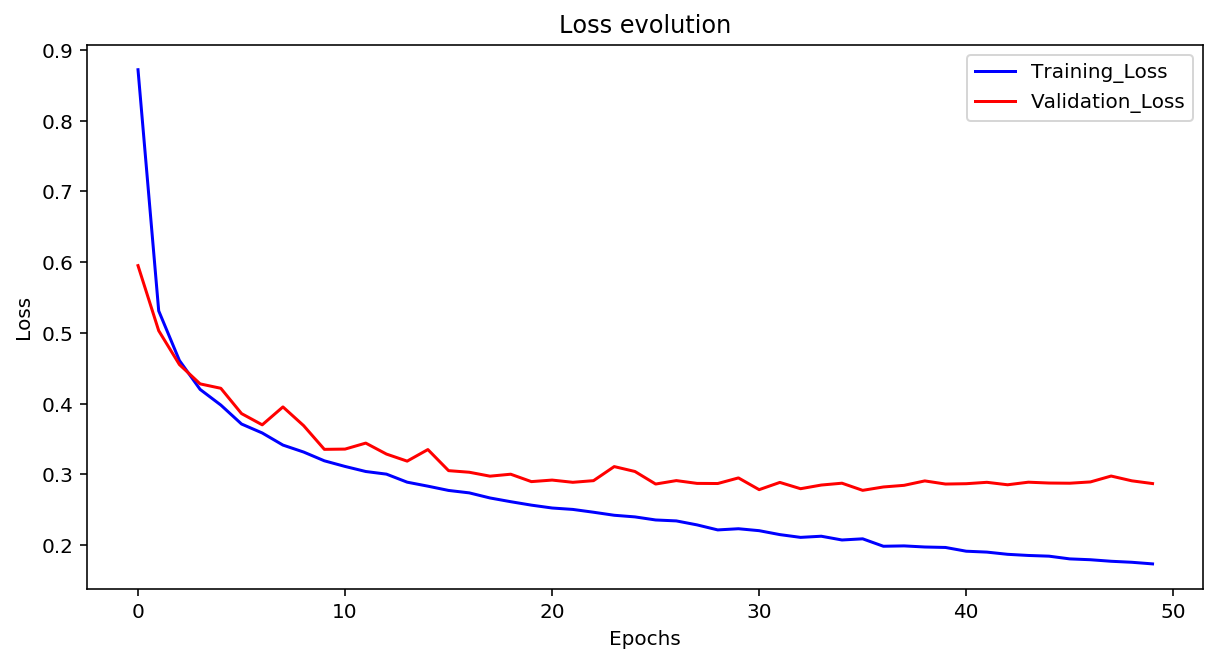

In [0]:

plt.figure(figsize=(10,5))
plt.plot(my_cnn_dropout2.loss_during_training,'b', label='Training_Loss')
plt.plot(my_cnn_dropout2.validation_loss_during_training,'r', label='Validation_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss evolution')
plt.legend()
plt.show()

In [0]:
my_cnn_dropout_all = Lenet5_extended_GPU_dropout_all(dimx=28,nlabels=10,epochs=50,lr=1e-3,prob=0.2)

my_cnn_dropout_all.trainloop(trainloader, validloader)

train_performance = my_cnn_dropout_all.eval_performance(trainloader)

test_performance = my_cnn_dropout_all.eval_performance(testloader)

print("Train Accuracy", train_performance)

print("Test Accuracy", test_performance)


Epoch 0. Training loss: 0.953338, Time per epoch: 5.406620 seconds
Epoch 1. Training loss: 0.573396, Time per epoch: 5.395045 seconds
Epoch 2. Training loss: 0.500120, Time per epoch: 5.379700 seconds
Epoch 3. Training loss: 0.450718, Time per epoch: 5.364470 seconds
Epoch 4. Training loss: 0.415486, Time per epoch: 5.298280 seconds
Epoch 5. Training loss: 0.396321, Time per epoch: 5.292681 seconds
Epoch 6. Training loss: 0.381160, Time per epoch: 5.245871 seconds
Epoch 7. Training loss: 0.364920, Time per epoch: 5.327567 seconds
Epoch 8. Training loss: 0.354171, Time per epoch: 5.218731 seconds
Epoch 9. Training loss: 0.342120, Time per epoch: 5.152054 seconds
Epoch 10. Training loss: 0.336208, Time per epoch: 5.484687 seconds
Epoch 11. Training loss: 0.326885, Time per epoch: 5.189563 seconds
Epoch 12. Training loss: 0.319779, Time per epoch: 5.221249 seconds
Epoch 13. Training loss: 0.313346, Time per epoch: 5.174926 seconds
Epoch 14. Training loss: 0.306469, Time per epoch: 5.21770

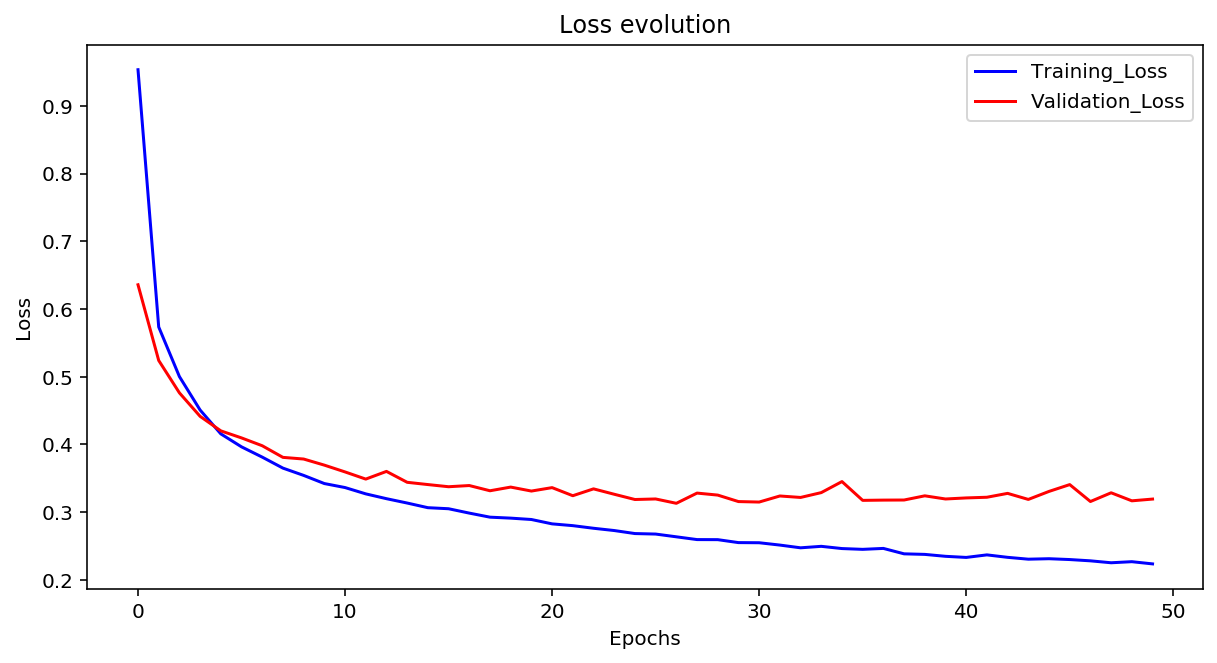

In [0]:

plt.figure(figsize=(10,5))
plt.plot(my_cnn_dropout_all.loss_during_training,'b', label='Training_Loss')
plt.plot(my_cnn_dropout_all.validation_loss_during_training,'r', label='Validation_Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss evolution')
plt.legend()
plt.show()